## Extracting charactheristic points from trajectories

In [1]:
import movingpandas as mp # needed to delete line calling contextily from trajectory.py
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import geopandas as gpd
from shapely.geometry import Point, Polygon
import warnings
import matplotlib.pyplot as plt
import descartes
import pyproj


gps = pd.read_csv('./sample_data/traj_full.csv')
gps.head()

gps['date_time'] = pd.to_datetime(gps['time'])
gps.shape

ids = np.array(["A", "B", "C"])
gps['user_id'] = np.repeat(ids, [37000, 37000, 38537], axis=0)

gps = gps.sort_values(by=['user_id', 'date_time'])

trips = gps.set_index('date_time')
lon_lat = [Point(xy) for xy in zip(trips.X, trips.Y)]
crs = {'init': 'epsg:4326'}
trips = gpd.GeoDataFrame(trips, crs=crs, geometry=lon_lat)
trips.head()


# to make everything faster I just selected the first 300 observations 
# for each user
#trips = trips.groupby('user_id').head(1000)
#trips.head()


#t_start = datetime.now()
#trajectories = []
#for key, values in trips.groupby(['user_id']):
#    trajectory = mp.Trajectory(key, values)
#    trajectories.append(trajectory)
#    print("Finished creating {} trajectories in {}".format(len(trajectories), datetime.now() - t_start)) 
    
geod = pyproj.Geod(ellps='WGS84')

# divide df in list of df by ID! -----------------------------------------


In [2]:
# make x and y coordiantes have X and Y nanmes
# how to deal with the time?

class Analyzer:
    def __init__(self,traj, max_distance, min_distance, min_stop_duration, min_angle = 45):
        self.i = 0 # initializing the indices
        self.j = 1
        self.k = 2
        self.traj = traj # corresponds to the input of the algorithm,
                         # the trajectory object of each user
        self.n = self.traj.shape[0] # I do this to get the number of 
                                               # points/GPS records of the trajectory
        self.max_distance = max_distance # parameter that I need to specify
        self.min_distance = min_distance # parameter that I need to specify
        self.min_stop_duration = min_stop_duration # parameter that I need to specify
        self.min_angle = min_angle # parameter that I need to specify
        self.last_point_index = self.traj.shape[0] - 1 # to obtain the 
                                                                  # index of the last coord 
                                                                  # of the trajectory
        # Below I obtain extract the first significant points of the trajectory,
        # that is, the first and last lon lat coordiantes
        self.significant_points = [(self.traj.X[0], self.traj.Y[0]),
                                   (self.traj.X[self.last_point_index], self.traj.Y[self.last_point_index])]
    
    # Start of algorithm ------------------------------------------------
    def find_significant_points(self): # this is the algorithm
        
        while self.j < self.n-1:
            
            #print(self.j)
            
            # function is_representative_max_distance is defined below the while 
            # loop, as well as the rest of the helper functions
            if self.is_representative_max_distance(): 
                #print("representative max distance at {0}".format(self.j))
                # with traj.to_linestring().coords[int(self.j)] I extract the jth 
                # coord of the trajectory
                self.significant_points.append((self.traj.X[int(self.j)], self.traj.Y[int(self.j)]))
                # update the indices
                self.i = self.j
                self.j = self.i + 1
                # I commented out continue statement, doesnt seem to make any difference
                #continue 
                
            elif self.more_points_further_than_min_distance():
                if self.k > self.j + 1: 
                    # d_time equal to difference in seconds between point k-1 and point j
                    d_time = (self.traj.index[int(self.k-1)] - self.traj.index[int(self.j)]).total_seconds()
                    if d_time >= self.min_stop_duration: 
                        #print("significant stop ({1}) at {0}".format(self.j,d_time))
                        self.significant_points.append((self.traj.X[int(self.j)], self.traj.Y[int(self.j)]))
                        self.i = self.j
                        self.j = self.k
                        #continue 
                    else:
                        # compute the average spatial position to represent the similar points
                        # Here I have a doubt, if I divide self.j + (self.k-1-self.j) by 2, sometimes the 
                        # result will not be an integer. Then, when I update the j index and try to use 
                        # it for accesing the jth element of a trajectory, it will return an error. Thats 
                        # why I decided to use integer division, so the return number is always an integer.
                        m = self.j + (self.k-1-self.j)//2 # had to use // instead of /
                        self.j = m # what is this m for?
                
                a_turn = self.compute_angle_between_vectors()
                #print("{0}: {1}".format(self.j,a_turn))
                if a_turn >= self.min_angle and a_turn <= (360-self.min_angle):
                    #print("significant angle ({0}) at {1}".format(a_turn,self.j))
                    self.significant_points.append((self.traj.X[int(self.j)], self.traj.Y[int(self.j)]))
                    self.i = self.j
                    self.j = self.k
                else:
                    self.j += 1
                        
            else:
                return self.significant_points
        
        return self.significant_points
    # end of algorithm ------------------------------------------------------------
   
    # here the helper functions that are called in the algorithm are defined.
    def compute_angle_between_vectors(self):
        # p_i = the ith point/lon lat coordiante of the trajectory 
        # e.g. (7.201938, 50.793915000000005)
        # I obtain the jth an kth coordiantes of the trajectory as well
        p_i = self.traj.X[int(self.i)], self.traj.Y[int(self.i)]
        p_j = self.traj.X[int(self.j)], self.traj.Y[int(self.j)]
        p_k = self.traj.X[int(self.k)], self.traj.Y[int(self.k)]
        # I calculate the azimuth between point i and j. 
        # geod.inv returns three values, in the first position is the 
        # forward azimuth, in second position back azimuth
        # and in third position the distance. Here I just 
        # return the forward azimuth between point i and j
        azimuth_ij = geod.inv(p_i[0], p_i[1], p_j[0], p_j[1])[0] # in position 0 is 
                                                                 # forward azimuth in 
                                                                 # position 2 is the distance. 
        
        # the same for point j and k
        azimuth_jk = geod.inv(p_j[0], p_j[1], p_k[0], p_k[1])[0]
        #print("{0} - {1}".format(azimuth_ij,azimuth_jk))
        # return absolute difference
        return abs(azimuth_ij - azimuth_jk) 
    
    def more_points_further_than_min_distance(self):
        for self.k in range(self.j+1,self.n):
            # get point j and k
            p_j = self.traj.X[int(self.j)], self.traj.Y[int(self.j)]
            p_k = self.traj.X[int(self.k)], self.traj.Y[int(self.k)]
            # calculate distance between both points
            d_space_j_k = geod.inv(p_j[0], p_j[1], p_k[0], p_k[1])[2]
            if d_space_j_k >= self.min_distance:
                return True
        return False
        
    def is_representative_max_distance(self):
        # I guess this is self explanatory now
        p_i = self.traj.X[int(self.i)], self.traj.Y[int(self.i)]
        p_j = self.traj.X[int(self.j)], self.traj.Y[int(self.j)]
        d_space = geod.inv(p_i[0], p_i[1], p_j[0], p_j[1])[2]
        
        if d_space >= self.max_distance:
            self.significant_points.append(p_i)
            return True
        else:
            return False

In [3]:
# get significant points ------------------------------------------------------
trips_group = trips.groupby('user_id')    

users = trips.user_id.unique()

import time
start = time.time()

significant_points = []
for u in users: 
    a = Analyzer(traj = trips_group.get_group(u), max_distance = 500, 
                         min_distance = 100, min_stop_duration = 300, min_angle = 45)
    significant_points = significant_points + a.find_significant_points()
    
end = time.time()
print(end - start)

70.30307841300964


## Grouping points in space

In [4]:
pts = significant_points

In [5]:
len(pts)

13561

In [6]:
#class for the object points
class ptt:
    #it has two variables x and y
    def __init__(self,x,y):

        self.x = x
        self.y = y
    #function to compute distance
    def distance(self,p):
        return ((p.x-self.x)**2+(p.y-self.y)**2)**0.5
    
    
#class group has two values : list of elements ans a centroid
class group:

    def __init__(self):

        self.members=[]
        self.centroid= None

#getting mins and from a list of points
def get_mins_and_max(points):
    xmin = points[0].x       
    xmax = points[0].x
    ymin = points[0].y
    ymax = points[0].y

    for point in points:  # maybe here it would be faster to use list comprehension instead of a for loop?
        if point.x < xmin: # something like x_min = min([x[0] for x in pts]) for getting min of X coordinates and so on! 
            xmin = point.x # I will be dealing with millions of points so any gain in performance is welcome.
        if point.y < ymin:
            ymin = point.y
        if point.x > xmax:
            xmax = point.x
        if point.y > ymax:
            ymax = point.y

    return xmin,xmax,ymin,ymax

#class grid has al elements ans functions necessary to manipulate the grid
class grid:
    def __init__(self,xmin,xmax,ymin,ymax,maxradius):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.maxradius =maxradius
        self.ncl= int((ymax-ymin)/maxradius)+1
        self.nrows=int((xmax-xmin)/maxradius)+1

        xstep=(xmax-xmin)/maxradius
        ystep=(ymax-ymin)/maxradius
        self.gridd = []
        for i in range(self.nrows):
            aux=[]
            for j in range(self.ncl):
                aux.append([])

            self.gridd.append(aux)
            
            
    #function that allows to get the position of a point inside the grid
    def get_grid_position(self,p):
        i=int((p.x-self.xmin)/self.maxradius)
        j = int((p.y - self.ymin) / self.maxradius)

        return i,j
    
    #this fuction allows to fill the grid from a set of points
    def fill_grid(self,points):
        
        for p in points:
            i,j=self.get_grid_position(p)
            self.gridd[i][j].append(p)
            
    #remove a point from the the grid
    def remove(self,point):
        
        i,j=self.get_grid_position(point)
        self.gridd[i][j].remove(point)
    

#get the centroid of a group of points
def get_centroid(points):
    x=[]
    y=[]
    for pp in points:
        x.append(pp.x)
        y.append(pp.y)

    x=float(sum(x)/len(x))
    y=sum(y)/len(y)
    pr=ptt(x,y)

    return pr
   
def put_in_proper_group(p,r ,grd):
    
    c=get_closest_centroid(p,grd)
    
    if c==None:
        g=group()
        g.members=[p]
        g.centroid=p
        r.append(g)

    else:
        for i in R:
            if i.centroid==c:
                g=i
                g.members.append(p)
                grd.remove(c)
                g.centroid=get_centroid(i.members)
                
    i,j=grd.get_grid_position(g.centroid)

    grd.gridd[i][j].append(g.centroid)

def get_closest_centroid(point,grid):
    i,j=grid.get_grid_position(point) # step 1 ------------
    
    C=[] # Step 2 -----------------


    for k in range(max(i-1,1),min(i+1,grid.nrows)):
        for m in range(max(j - 1, 1), min(j + 1, grid.ncl)):
            for c in grid.gridd[i][j]:  # grid.gridd -> G.cell in paper. Should be grid.gridd[k][m]?
                distance=point.distance(c)

                if distance < grid.maxradius: # should be <= 
                    C.append(c)
    if C==[]: # step 3 -------------
        return None
    else: # step 4 ----
          # if C contains several centroids, take the one that is the closest to p

        return get_closest_centroid2(point,C) # C are the centroids
        
        
def get_closest_centroid2(point,centroids): # find the closest centroid to p
    closest=centroids[0] # is it centroids[0] the closest centroid?
    for c in centroids:
        if c.distance(point) < closest.distance(point):
            closest=c
    return closest
    
        
def redistributePoints(pp,rr,gg):
    for group in rr:
        group.members=[]
    for p in pp:
        c=get_closest_centroid(p,gg)
        for g in rr:
            if g.centroid==c:
                g.members.append(p)
                break

# Main algorithm ---------------------------------------------                
points=[]
maxradius=0.01  #close to 1110m
R=[]

# here he created the points from the list of tuples
for pp in pts:
    aux=ptt(pp[0],pp[1])
    points.append(aux)

xmin,xmax,ymin,ymax=get_mins_and_max(points)
#print(xmin,xmax,ymin,ymax)

grd=grid(xmin,xmax,ymin,ymax,maxradius)

#print(grd.gridd[5]) why it returns and empty grid?


grd = grid(xmin, xmax, ymin, ymax, maxradius)

R = []

for p in points:
    put_in_proper_group(p, R, grd)


redistributePoints(points, R, grd)

#for g in R:
#    print('Centroid:',g.centroid.x,g.centroid.y)
#    print('Members:')
#    for pg in g.members:
#        print('     ',pg.x,pg.y)
#        print(' ')

In [7]:
len(R)

236

In [8]:
centroids_coords = []
for g in R:
    centroids_coords.append([g.centroid.x, g.centroid.y])

In [9]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
vor = Voronoi(centroids_coords)

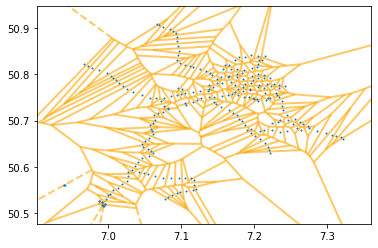

In [10]:
fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange',
                line_width=2, line_alpha=0.6, point_size=2)

plt.show()

## Compute flows between cells from trajectories


In [ ]:
centroids_coords

In [ ]:
##Trajectory generalization=group
##input_trajectories=vector
##weight_field=field input_trajectories
##use_weight_field=boolean
##input_cell_centers=vector
##flow_lines=output vector
##cell_counts=output vector 


from datetime import datetime, timedelta 


class SequenceGenerator():
    def __init__(self,centroid_layer,trajectory_layer,weight_field=None):
        centroids = [f for f in centroid_layer.getFeatures()]
        self.cell_index = QgsSpatialIndex()
        for f in centroids:
            self.cell_index.insertFeature(f)
        self.id_to_centroid = {f.id(): [f,[0,0,0,0,0]] for (f) in centroids}
        self.weight_field = weight_field
        if weight_field is not None:
            self.weightIdx = trajectory_layer.fieldNameIndex(weight_field)
        else:
            self.weightIdx = None
        self.sequences = {}
        
        nTraj = float(trajectory_layer.featureCount())
        for i,traj in enumerate(trajectory_layer.getFeatures()):
            self.evaluate_trajectory(traj)
            progress.setPercentage(i/nTraj*100)
            
    def evaluate_trajectory(self,trajectory):
        points = trajectory.geometry().asPolyline()
        this_sequence = []
        weight = 1 if self.weight_field is None else trajectory.attributes()[self.weightIdx]
        prev_cell_id = None
        for i, pt in enumerate(points):
            id = self.cell_index.nearestNeighbor(pt,1)[0]
            nearest_cell = self.id_to_centroid[id][0]
            nearest_cell_id = nearest_cell.id()
            if len(this_sequence) >= 1:
                prev_cell_id = this_sequence[-1]
                if nearest_cell_id != prev_cell_id:
                    if self.sequences.has_key((prev_cell_id,nearest_cell_id)):
                        self.sequences[(prev_cell_id,nearest_cell_id)] += weight
                    else:
                        self.sequences[(prev_cell_id,nearest_cell_id)] = weight
            if nearest_cell_id != prev_cell_id: 
                # we have changed to a new cell --> up the counter 
                m = trajectory.geometry().geometry().pointN(i).m()
                t = datetime(1970,1,1) + timedelta(seconds=m) + timedelta(hours=8) # Beijing GMT+8
                h = t.hour 
                self.id_to_centroid[id][1][0] += weight
                self.id_to_centroid[id][1][h/6+1] += weight
                this_sequence.append(nearest_cell_id)
    
    def create_flow_lines(self):
        lines = []
        for key,value in self.sequences.iteritems(): 
            p1 = self.id_to_centroid[key[0]][0].geometry().asPoint()
            p2 = self.id_to_centroid[key[1]][0].geometry().asPoint()
            feat = QgsFeature()
            feat.setGeometry(QgsGeometry.fromPolyline([p1,p2]))
            feat.setAttributes([key[0],key[1],value])
            lines.append(feat)
        return lines

centroid_layer = processing.getObject(input_cell_centers)
trajectory_layer = processing.getObject(input_trajectories)
sg = SequenceGenerator(centroid_layer,trajectory_layer, weight_field if use_weight_field else None)

fields = [QgsField('FROM', QVariant.Int),
              QgsField('TO', QVariant.Int),
              QgsField('COUNT', QVariant.Int)]
geom_type = 2
writer = VectorWriter(flow_lines, None, fields, geom_type, centroid_layer.crs() )
for f in sg.create_flow_lines():
    writer.addFeature(f)
del writer 

fields = centroid_layer.fields()
fields.append( QgsField('COUNT',QVariant.Int))
fields.append( QgsField('COUNT_Q1',QVariant.Int))
fields.append( QgsField('COUNT_Q2',QVariant.Int))
fields.append( QgsField('COUNT_Q3',QVariant.Int))
fields.append( QgsField('COUNT_Q4',QVariant.Int))
writer = VectorWriter(cell_counts, None, fields, 1, centroid_layer.crs() )
for key, value in sg.id_to_centroid.iteritems():
    (in_feature, n) = value
    out_feature = QgsFeature()
    out_feature.setGeometry(in_feature.geometry())
    attributes = in_feature.attributes()
    attributes.append(n[0])
    attributes.append(n[1])
    attributes.append(n[2])
    attributes.append(n[3])
    attributes.append(n[4])
    out_feature.setAttributes(attributes)
    writer.addFeature(out_feature)
del writer